# Sleep EEG preprocessing, spectral analyses and events detection

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA and spectral analyses stages.
* For the cleaning part the functionality consists of resampling, filtering, bad channel selection and interpolation, and annotation of bad data spans.
* For the ICA part it is fitting and selecting components you want to exclude.
* For the spectral analyses part it is spectrogram+hypnogram, PSD per sleep stage and topomap per sleep stage per frequency band.
* For the events detection it is spindles, slow waves and rapid eye movements detection.

For the extended functionality check out corresponding notebooks.

### Import module
Add pipeline module to path and import its elements (just run this cell).

In [1]:
%matplotlib widget
from sleepeeg.pipeline import (
    CleaningPipe, ICAPipe, SpectralPipe, 
    SpindlesPipe, SlowWavesPipe, REMsPipe
    )

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [2]:
pipe = CleaningPipe(
    path_to_eeg=r"C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff",
    output_dir=r"C:\Users\Gennadiy\Documents\data\HZ4\processing")

Reading EGI MFF Header from C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff...
    Reading events ...
    Assembling measurement info ...


### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [3]:
pipe.mne_raw.load_data()

Reading 0 ... 8919090  =      0.000 ...  8919.090 secs...


<RawMff | signal1.bin, 264 x 8919091 (8919.1 s), ~17.54 GB, data loaded>

In [4]:
pipe.resample(
    mne_resample_args=dict(  # Arguments passed to the mne's raw.resample()
        sfreq=250,  # Desired new sampling frequency
    )
)

### Filtering
Bandpass and notch filters

In [5]:
pipe.filter(mne_filter_args=dict(  # Arguments passed to the mne's raw.filter()
        l_freq=0.3,
        h_freq=None
        )
)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 2751 samples (11.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   10.4s finished


In [6]:
pipe.notch(
    mne_notch_args=dict(  # Arguments passed to the mne's raw.notch_filter()
        picks='eeg',  # If None - filter all channels
    )
)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:    9.4s finished


### Select bad channels and epochs

Select bad channels in the opened browser.

In [ ]:
pipe.plot()

In [7]:
pipe.read_bad_channels()

In [8]:
pipe.mne_raw.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 220 sensor positions
Interpolating 37 sensors


<RawMff | signal1.bin, 264 x 2229773 (8919.1 s), ~4.39 GB, data loaded>

Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [ ]:
pipe.plot(butterfly=True)

In [9]:
pipe.read_annotations()

## ICA

Pass the preceding (cleaning) pipe to the ICA.

In [10]:
ica_pipe = ICAPipe(
    prec_pipe=pipe)

Fit the ICA on the 1 Hz high-pass fitered data.

In [ ]:
ica_pipe.fit()

Visually inspect ICA components.

In [ ]:
ica_pipe.plot_sources()

Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [ ]:
ica_pipe.apply(exclude=[11])

## Spectral

Pass the preceding (cleaning or ICA) pipe to the SpectralPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [11]:
spectral_pipe = SpectralPipe(
    prec_pipe=ica_pipe,
    path_to_hypno=r"C:\Users\Gennadiy\Documents\data\HZ4\staging.txt",
    hypno_freq=1)

09-May-23 13:12:46 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


If you don't have a hypnogram, you can use the method `predict_hypno`, which will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging). 

Make sure that the electrodes you provide are clean.

In [ ]:
# spectral_pipe.predict_hypno(
#         eeg_name = "E183",
#         eog_name = "E252",
#         emg_name = "E247",
#         ref_name = "E26",
#         save=False
# )

Pass an electrode name to calculate spectrogram for (e.g., E101)

Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.


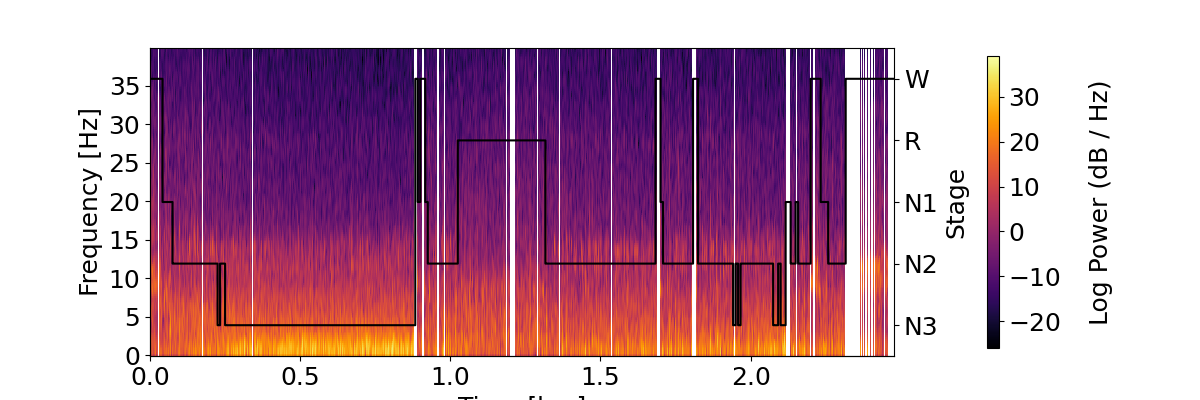

In [15]:
spectral_pipe.plot_hypnospectrogram(
    picks=['E101'],
    overlap=True)

Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.


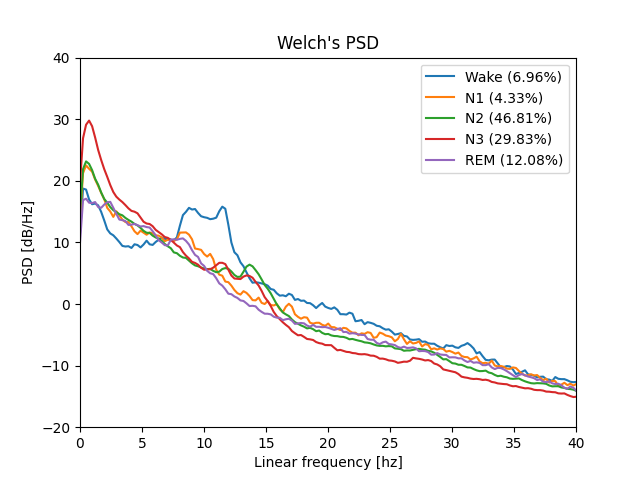

In [16]:
spectral_pipe.plot_psd_per_stage(
    picks=['E101'],
    psd_range=(-20, 40))

Create a collage with rows for sleep stages and columns for bands.

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.


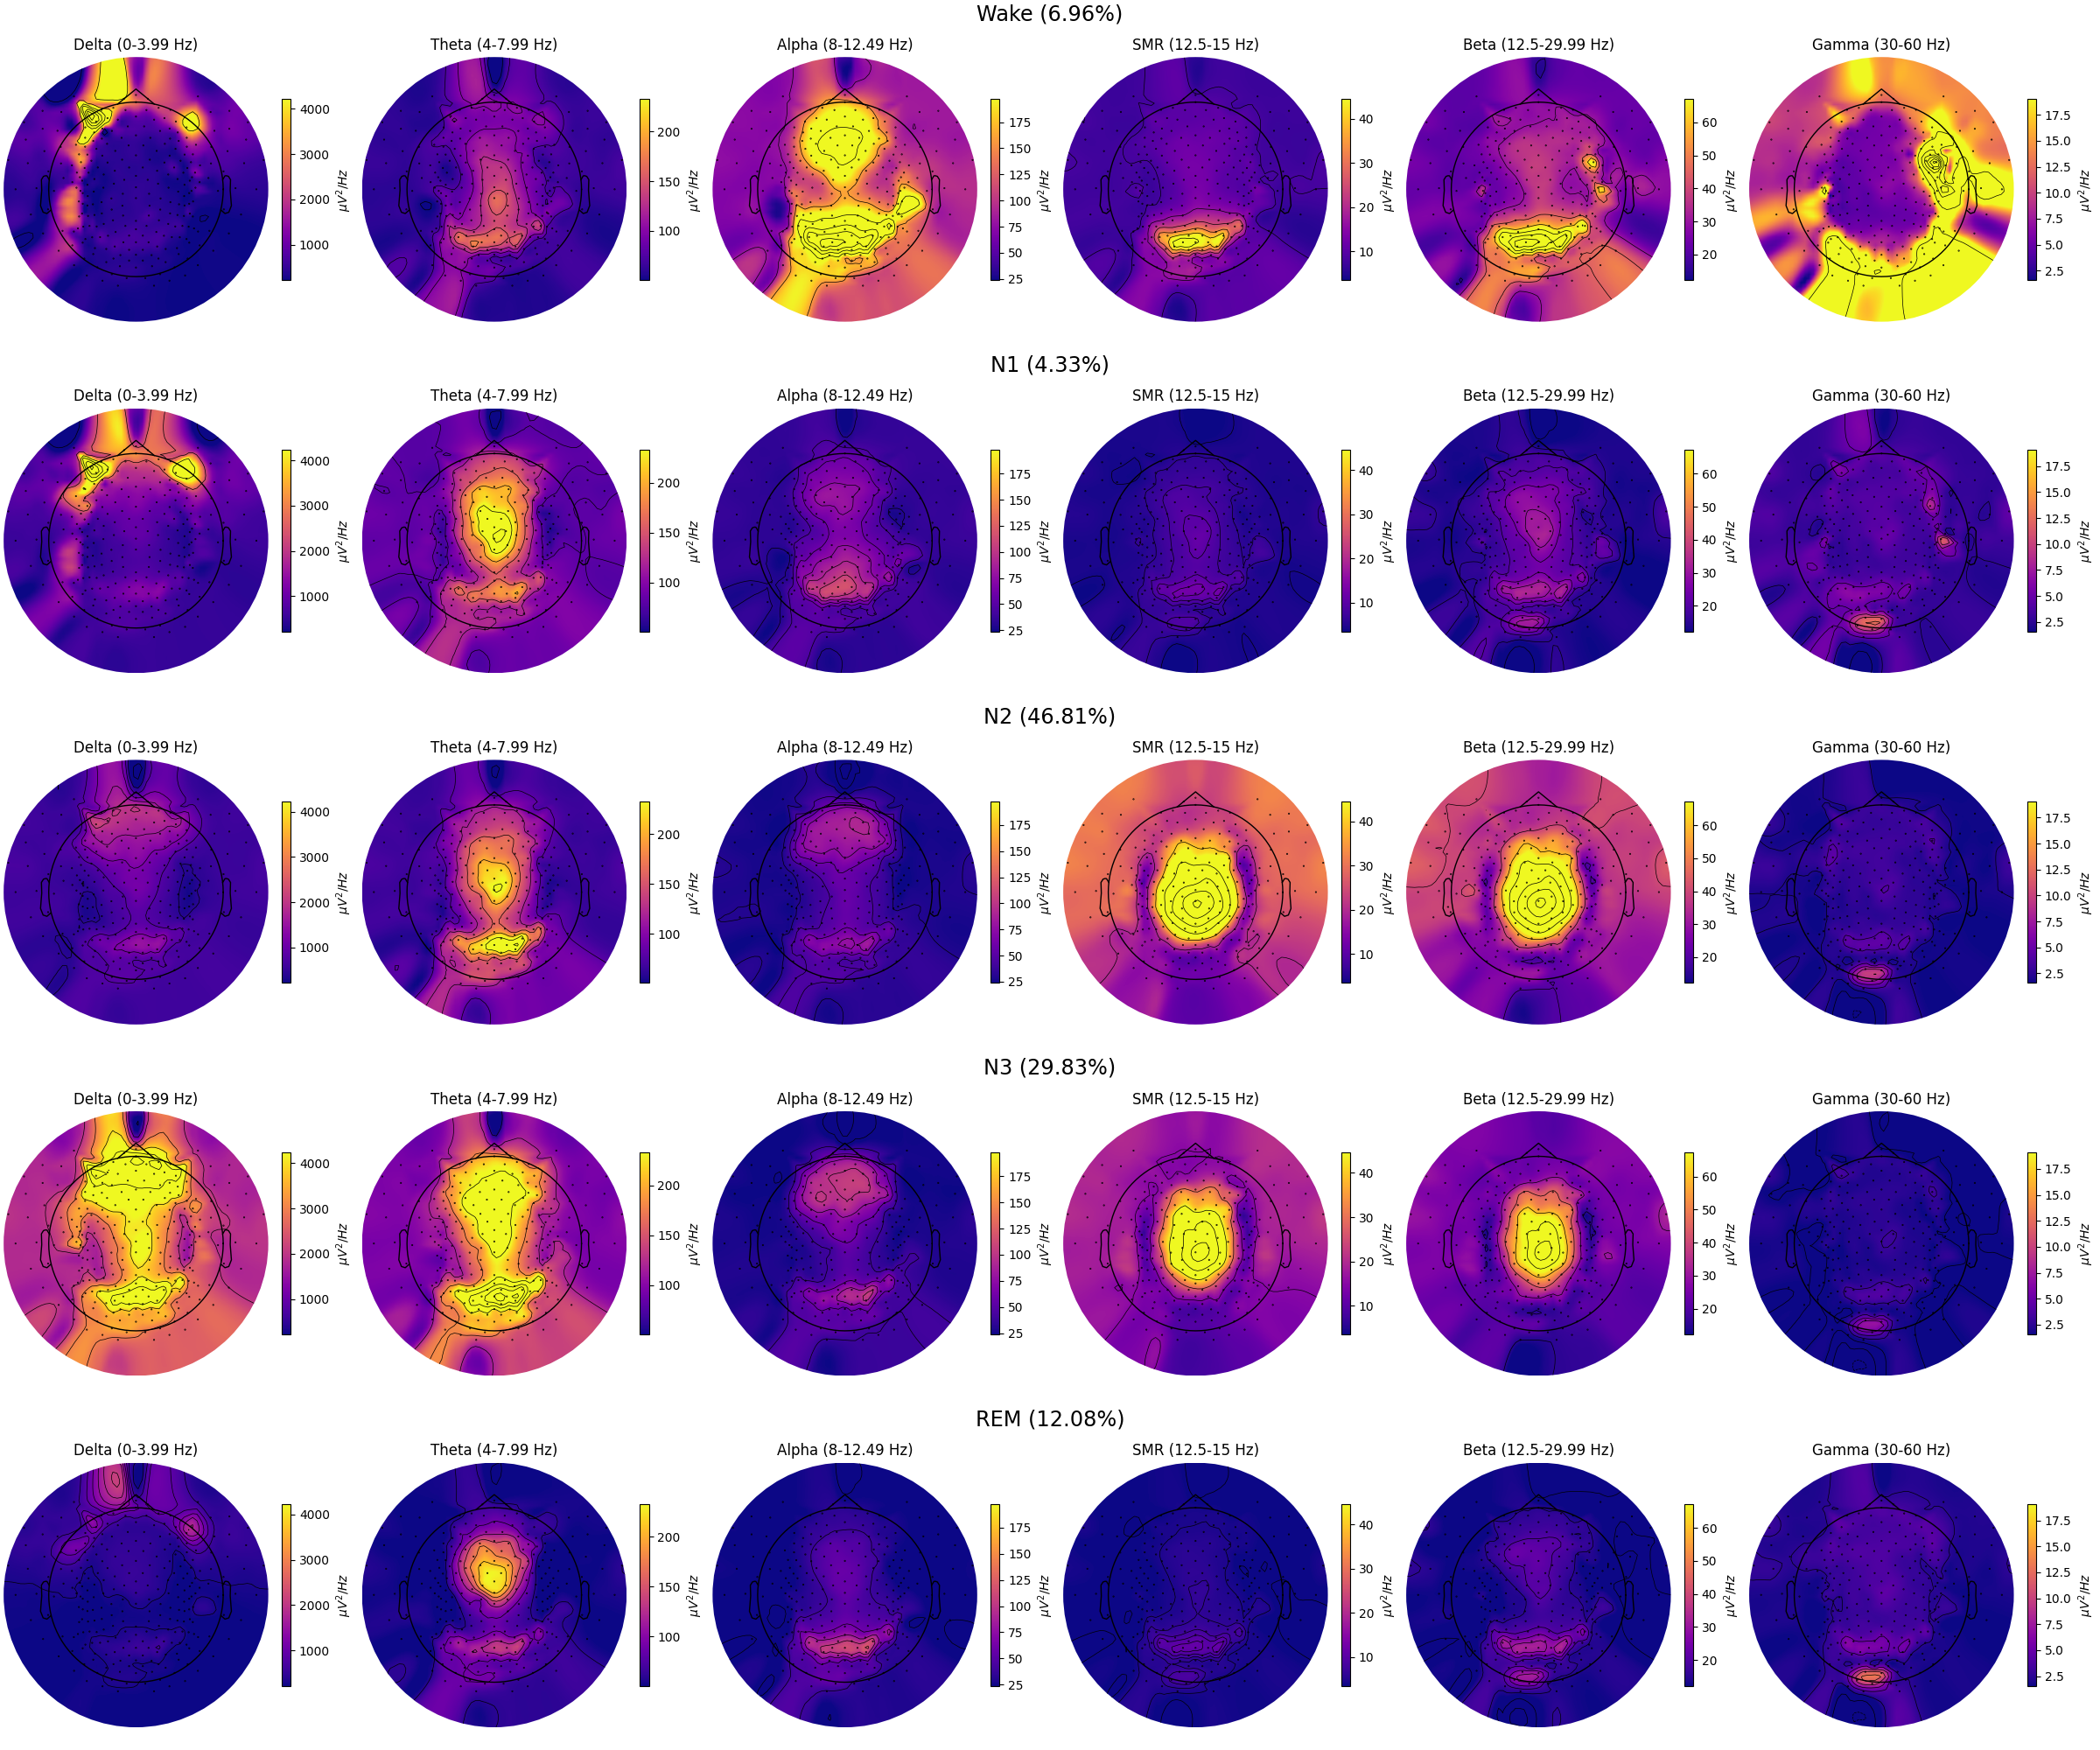

In [17]:
spectral_pipe.plot_topomap_collage()

## Events

Pass the preceding (cleaning or ICA or spectral) pipe to one of the SpindlesPipe, SlowWavesPipe or REMsPipe. If the preceding is cleaning or ICA - provide path to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

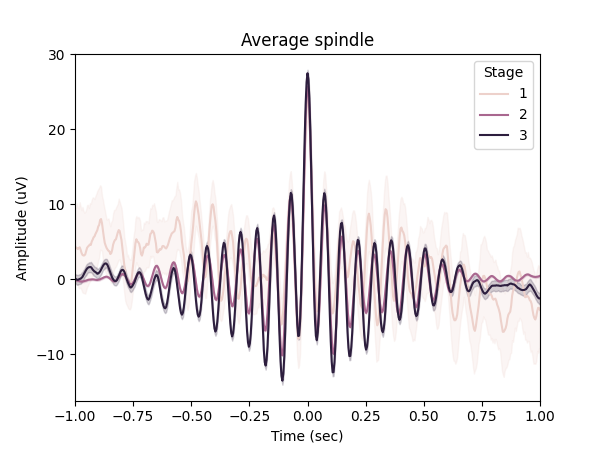

In [16]:
spindles_pipe = SpindlesPipe(
    prec_pipe=spectral_pipe)
    
spindles_pipe.detect()
spindles_pipe.plot_average(
        yasa_args=dict(
        center="Peak",
        hue="Stage",
        time_before=1,
        time_after=1,
    )
)

100%|██████████| 88/88 [00:01<00:00, 82.00it/s]


No baseline correction applied


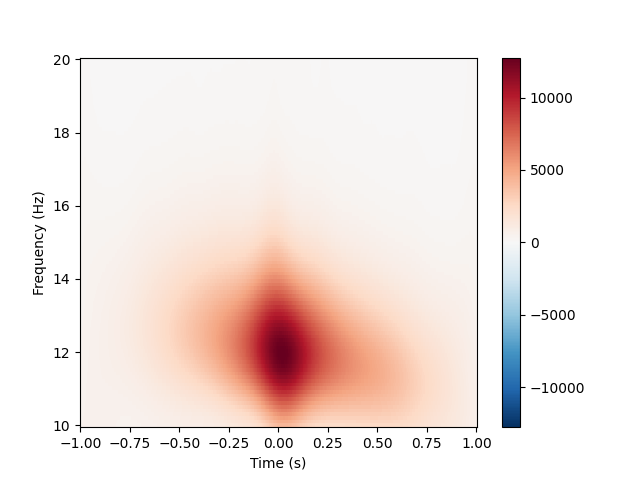

[<Figure size 640x480 with 2 Axes>]

In [17]:
spindles_pipe.apply_tfr(
    freqs=(10,20), 
    n_freqs=100, 
    time_before=1, 
    time_after=1)
spindles_pipe.tfrs['N2'].plot(['E101'])

09-May-23 13:45:06 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   10.7s finished


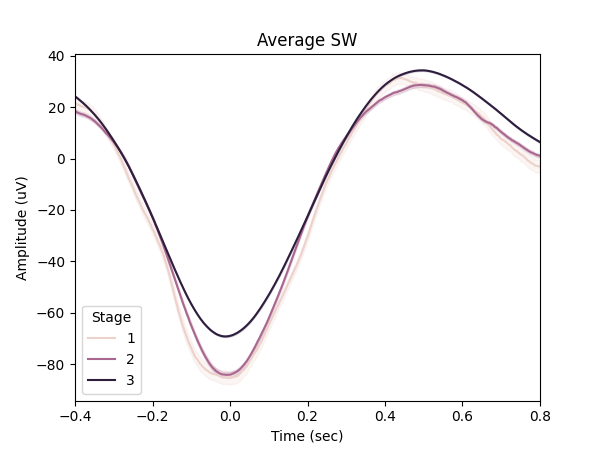

In [18]:
slow_waves_pipe = SlowWavesPipe(
    prec_pipe=spindles_pipe)
    
slow_waves_pipe.detect()
slow_waves_pipe.plot_average(
    yasa_args=dict(
        center="NegPeak",
        hue="Stage",
        time_before=0.4,
        time_after=0.8,
    )
)

100%|██████████| 252/252 [00:12<00:00, 20.17it/s]


No baseline correction applied


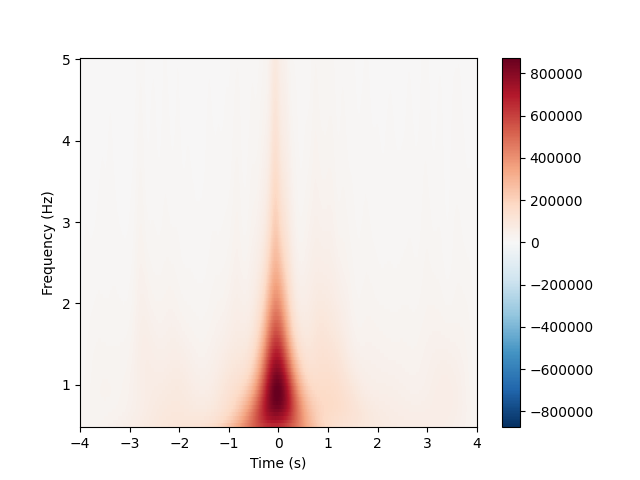

[<Figure size 640x480 with 2 Axes>]

In [20]:
slow_waves_pipe.apply_tfr(
    freqs=(0.5,5), 
    n_freqs=100, 
    time_before=4, 
    time_after=4, 
    tfr_method_args=dict(n_cycles=2)
    )
slow_waves_pipe.tfrs['N2'].plot(['E101'])

09-May-23 14:05:37 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.
Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


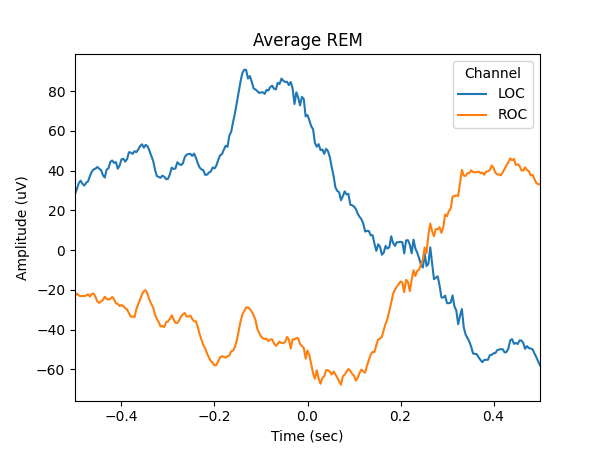

In [21]:
rems_pipe = REMsPipe(
    prec_pipe=slow_waves_pipe)
    
rems_pipe.detect(        
    loc_chname="E252",
    roc_chname="E226",)

rems_pipe.plot_average(
    yasa_args=dict(
        center="Peak",
        time_before=0.5,
        time_after=0.5,
        filt=(None,None),
        mask=None,
    )
)